# 1. Library installation and data read-in

In [3]:
# general functions
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

dataset_path = "../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"

     |████████████████████████████████| 2.3MB 2.1MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


Using TensorFlow backend.


In [5]:
# Data read-in and cleaning

lfw_allnames = pd.read_csv("../input/lfw-dataset/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("../input/lfw-dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("../input/lfw-dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("../input/lfw-dataset/pairs.csv")
# tidy pairs data: 
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("../input/lfw-dataset/people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("../input/lfw-dataset/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("../input/lfw-dataset/peopleDevTrain.csv")

# 2. Exploratory Data Analysis (EDA)

In [6]:
print("Summary:")
print("There are " + 
      str(lfw_allnames.shape[0]) + 
      " unique celebrities in the entire dataset, of whom " + 
      str(sum(lfw_allnames.images > 1)) + 
      " are represented by multiple images. The entire number of images available is " + 
      str(sum(lfw_allnames.images)) + 
      ". The most represented celebrity is " + 
      str(lfw_allnames.iloc[lfw_allnames['images'].idxmax()][0]) + 
      ", with " + 
      str(max(lfw_allnames.images)) + 
      " unique images in the dataset.")

Summary:
There are 5749 unique celebrities in the entire dataset, of whom 1680 are represented by multiple images. The entire number of images available is 13233. The most represented celebrity is George_W_Bush, with 530 unique images in the dataset.


In [7]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

# both comprehensively non-empty - we are ok to procede.
# N.B. although we don't use this training/test split in the following model, this is the format of the data we
# would use in applying models to the full dataset

852
842


### Image format exploration

In [8]:
# verify resolution of all images is consistent
widths = []
heights = []
files = image_paths.image_path
for file in files:
    path = "../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(file)
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

pd.DataFrame({'height':heights,'width':widths}).describe()

# all 250 x 250 resolution

,height,width
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


### Further data exploration

One of the drawbacks of the LFW dataset is that if has significant class imbalance. This can be dealt with using selective sampling, but it is useful to get an indication of the scale of the imbalance:

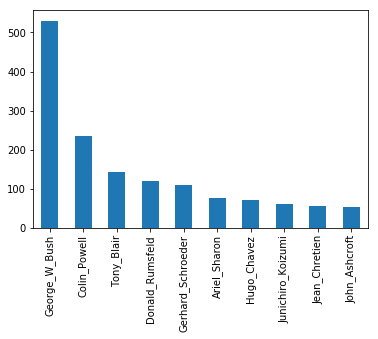

In [9]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

We can see that there are some very well-represented figures among the top 10: generally political and generally male. This has important implications for the usefulness of this dataset in generalizations, which we consider in the conclusion. To draw this further into distinction, how many individuals are represented by a single image, compared to George W Bush's 530? 

In [10]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " individuals, which is " + str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) + "% of the total individuals considered, are only represented by a single image in this dataset.")

4069 individuals, which is 31% of the total individuals considered, are only represented by a single image in this dataset.


As a sanity check, and to check the directories are all correctly connected, we visualize a sample image:

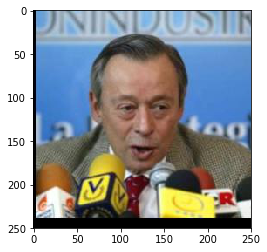

In [11]:
im = Image.open("../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
plt.imshow(im)

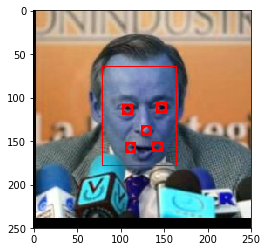

In [33]:
# Use out-of-the-box MTCNN algorithm to identify facial boundaries on a sample image
detector = MTCNN()
image = cv2.imread("../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
result = detector.detect_faces(image)
# That's it - the results have already been generated! Now we extract the boundaries that have been identified 
bounding_box = result[0]['box']
keypoints = result[0]['keypoints']

# Finally, we plot the image along with the face's bounding box and internal features (eyes, nose, and mouth corners)
fig,ax = plt.subplots(1)
ax.imshow(image)
# Create a Rectangle patch
rect = patches.Rectangle(bounding_box[0:2],bounding_box[2],bounding_box[3],linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
# Visualize all the internal features
for key in keypoints:
    rect_key = patches.Rectangle(keypoints[key],1,1,linewidth=10,edgecolor='r',facecolor='none')
    ax.add_patch(rect_key)
# Show the plots
plt.show()

We don't use these features in the main CNN models below, but they would be useful feature inputs for future models.

In [34]:
# initialize sequential network
from keras.models import Sequential
# include convolutional layers
from keras.layers import Conv2D
# Pooling layers
from keras.layers import MaxPooling2D, BatchNormalization, Dropout
# flatten layers into single vector
from keras.layers import Flatten
from keras.layers import Dense, Softmax

The model is now ready to run, but there is a final step required: the model will read training files from a dedicated training folder, so we need to make sure all the images are in folders with the correct labels. 

In [35]:
# define a custom function to move images to a new train/test/val directory

def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('/kaggle/working/',dir_name)):
            shutil.os.mkdir(os.path.join('/kaggle/working/',dir_name))
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('/kaggle/working/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('/kaggle/working/',dir_name,data_type))
        path_from = os.path.join('../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/',image)
        path_to = os.path.join('/kaggle/working/',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1
        
    print('Moved {} images to {} folder.'.format(co,dir_name))

In [36]:
from keras.preprocessing import image

# create a function to predict class of images in a directory, given a trained classifier
def predictions(dir_name,classifier,binary):
    # dir_name should include name of predicted invididual - could edit this to iterate through folders in future
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size = (250,250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        if(binary is True):
            result = float(str(classifier.predict(test_image))[2])
        else: 
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)


In [37]:
# function for finding the precision and recall of predictions, for any number of predictive classes
def prec_acc(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    for i in range(len(set(predictions_frame.Predictions))):
        tp = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] != i)].shape[0]
        fp = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] == i)].shape[0]
        fn = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] != i)].shape[0]
        total_preds = predictions_frame.shape[0]
        precision.append(tp/(tp + fp))
        accuracy.append((tp + tn)/total_preds)
        recall.append(tp/(tp + fn))
    return(accuracy,precision,recall)

In [38]:
# obtain 6 most common celebrities

image_paths['name'].value_counts()[:6]

George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Name: name, dtype: int64

In [39]:
multi_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(75),
                        image_paths[image_paths.name=="Colin_Powell"].sample(75),
                        image_paths[image_paths.name=="Tony_Blair"].sample(75),
                        image_paths[image_paths.name=="Donald_Rumsfeld"].sample(75),
                        image_paths[image_paths.name=="Gerhard_Schroeder"].sample(75),
                        image_paths[image_paths.name=="Ariel_Sharon"].sample(75)])

We then run the model as before, adjusting for multiple classes:

In [23]:
# withhold final test data
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)
# split into validation data
multi_train, multi_val = train_test_split(multi_train,test_size=0.2)

# Same model setup as before
multi_classifier = Sequential()
multi_classifier.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (250, 250, 3), activation = 'relu'))
multi_classifier.add(BatchNormalization())
multi_classifier.add(MaxPooling2D(pool_size = (2, 2), strides =(2,2)))
multi_classifier.add(Dropout(0.5))

multi_classifier.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
multi_classifier.add(BatchNormalization())
multi_classifier.add(MaxPooling2D(pool_size = (2, 2), strides =(2,2)))
multi_classifier.add(Dropout(0.5))

multi_classifier.add(Conv2D(128, (3, 3), padding = 'same',  activation = 'relu'))
multi_classifier.add(BatchNormalization())
multi_classifier.add(MaxPooling2D(pool_size = (2, 2), strides =(2,2)))
multi_classifier.add(Dropout(0.5))

multi_classifier.add(Conv2D(256, (3, 3), padding = 'same',activation = 'relu'))
multi_classifier.add(BatchNormalization())
multi_classifier.add(MaxPooling2D(pool_size = (2, 2), strides =(2,2)))
multi_classifier.add(Dropout(0.5))


multi_classifier.add(Flatten())
multi_classifier.add(Softmax())
multi_classifier.add(Dense(units = 128, activation = 'relu'))



# as we are training on several classes, we need several classification units (one for each class). We also use a 
# softmax activation function
multi_classifier.add(Dense(units = 6, activation = 'softmax'))
# we change the loss function to categorical_crossentropy
multi_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# move images to separate directories
directory_mover(multi_train,"train_multi/")
directory_mover(multi_val,"val_multi/")
directory_mover(multi_test,"test_multi/")

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
multi_training_set = train_datagen.flow_from_directory('/kaggle/working/train_multi/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
multi_val_set = test_datagen.flow_from_directory('/kaggle/working/val_multi/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'categorical')
multi_test_set = test_datagen.flow_from_directory('/kaggle/working/test_multi/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'categorical')


multi_history = multi_classifier.fit_generator(multi_training_set,
                                               # set steps per epoch equal to the number of training images
                                               steps_per_epoch = 288,
                                               # as the data is smaller, we can run for more epochs
                                               epochs = 14,
                                               validation_data = multi_val_set,
                                               validation_steps = 72)

Moved 288 images to train_multi/ folder.
Moved 72 images to val_multi/ folder.
Moved 90 images to test_multi/ folder.
Found 401 images belonging to 6 classes.
Found 132 images belonging to 6 classes.
Found 165 images belonging to 6 classes.
Epoch 1/14
288/288 [==============================] - 133s 463ms/step - loss: 1.7847 - accuracy: 0.1957 - val_loss: 1.7863 - val_accuracy: 0.1904
Epoch 2/14
288/288 [==============================] - 126s 439ms/step - loss: 1.5119 - accuracy: 0.4100 - val_loss: 1.5515 - val_accuracy: 0.5063
Epoch 3/14
288/288 [==============================] - 126s 438ms/step - loss: 1.2313 - accuracy: 0.5436 - val_loss: 1.5054 - val_accuracy: 0.2734
Epoch 4/14
288/288 [==============================] - 128s 443ms/step - loss: 1.0253 - accuracy: 0.6377 - val_loss: 1.4743 - val_accuracy: 0.3185
Epoch 5/14
288/288 [==============================] - 129s 447ms/step - loss: 0.8414 - accuracy: 0.7110 - val_loss: 1.6892 - val_accuracy: 0.3923
Epoch 6/14
288/288 [=========

In [23]:
import tensorflow as tf

In [50]:
def ResNet34(shape = (250, 250, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(6, activation = 'softmax')(x)
    model2 = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model2

In [51]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def identity_block(x, filter):
    
    # copy tensor to variable called x_skip
    x_skip = x
    
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [52]:
model2 = ResNet34()
model2.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model2.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 256, 256, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_180 (Conv2D)             (None, 128, 128, 64) 9472        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
batch_normalization_132 (BatchN (None, 128, 128, 64) 256         conv2d_180[0][0]                 
___________________________________________________________________________________________

In [53]:
# withhold final test data
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)
# split into validation data
multi_train, multi_val = train_test_split(multi_train,test_size=0.2)
directory_mover(multi_train,"train_multi/")
directory_mover(multi_val,"val_multi/")
directory_mover(multi_test,"test_multi/")

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
multi_training_set = train_datagen.flow_from_directory('/kaggle/working/train_multi/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
multi_val_set = test_datagen.flow_from_directory('/kaggle/working/val_multi/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'categorical')
multi_test_set = test_datagen.flow_from_directory('/kaggle/working/test_multi/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'categorical')


multi_history = model2.fit_generator(multi_training_set,
                                               # set steps per epoch equal to the number of training images
                                               steps_per_epoch = 288,
                                               # as the data is smaller, we can run for more epochs
                                               epochs = 14,
                                               validation_data = multi_val_set,
                                               validation_steps = 72)

Moved 288 images to train_multi/ folder.
Moved 72 images to val_multi/ folder.
Moved 90 images to test_multi/ folder.
Found 448 images belonging to 6 classes.
Found 272 images belonging to 6 classes.
Found 310 images belonging to 6 classes.
Epoch 1/14
288/288 [==============================] - 168s 584ms/step - loss: 2.5145 - acc: 0.2731 - val_loss: 1.2521 - val_acc: 0.5294
Epoch 2/14
288/288 [==============================] - 154s 535ms/step - loss: 0.8059 - acc: 0.6994 - val_loss: 0.8191 - val_acc: 0.7978
Epoch 3/14
288/288 [==============================] - 152s 526ms/step - loss: 0.2390 - acc: 0.9157 - val_loss: 0.0995 - val_acc: 0.9706
Epoch 4/14
288/288 [==============================] - 154s 535ms/step - loss: 0.0977 - acc: 0.9670 - val_loss: 0.1204 - val_acc: 0.9559
Epoch 5/14
288/288 [==============================] - 149s 519ms/step - loss: 0.0689 - acc: 0.9783 - val_loss: 0.7798 - val_acc: 0.8309
Epoch 6/14
288/288 [==============================] - 153s 530ms/step - loss: 0

In [42]:
multi_classifier = Sequential()
multi_classifier.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (250, 250, 3), activation = 'relu'))
multi_classifier.add(BatchNormalization())
multi_classifier.add(MaxPooling2D(pool_size = (2, 2), strides =(2,2)))
multi_classifier.add(Dropout(0.5))

multi_classifier.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
multi_classifier.add(BatchNormalization())
multi_classifier.add(MaxPooling2D(pool_size = (2, 2), strides =(2,2)))
multi_classifier.add(Dropout(0.5))

multi_classifier.add(Conv2D(128, (3, 3), padding = 'same',  activation = 'relu'))
multi_classifier.add(BatchNormalization())
multi_classifier.add(MaxPooling2D(pool_size = (2, 2), strides =(2,2)))
multi_classifier.add(Dropout(0.5))

multi_classifier.add(Conv2D(256, (3, 3), padding = 'same',activation = 'relu'))
multi_classifier.add(BatchNormalization())
multi_classifier.add(MaxPooling2D(pool_size = (2, 2), strides =(2,2)))
multi_classifier.add(Dropout(0.5))

multi_classifier.add(Conv2D(512, (3, 3), padding = 'same',activation = 'relu'))
multi_classifier.add(BatchNormalization())
multi_classifier.add(MaxPooling2D(pool_size = (2, 2), strides =(2,2)))
multi_classifier.add(Dropout(0.5))

multi_classifier.add(Flatten())
multi_classifier.add(Softmax())
multi_classifier.add(Dense(units = 128, activation = 'relu'))


In [29]:
from keras.preprocessing import image

test_image = image.load_img('./test_multi/George_W_Bush/George_W_Bush_0094.jpg', target_size = (250,250))
test_image =image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis =0)

model2.predict(test_image)

FileNotFoundError: [Errno 2] No such file or directory: './test_multi/George_W_Bush/George_W_Bush_0094.jpg'

In [60]:
predict = multi_classifier.predict('./test_multi/Donald_Rumsfeld/Donald_Rumsfeld_0051.jpg')

AttributeError: 'str' object has no attribute 'ndim'

In [41]:
multi_classifier.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 250, 250, 32)      896       
_________________________________________________________________
batch_normalization_32 (Batc (None, 250, 250, 32)      128       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 125, 125, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_33 (Batc (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 62, 62, 64)      

Again, it is useful to check for convergence:

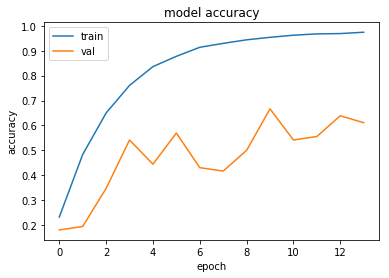

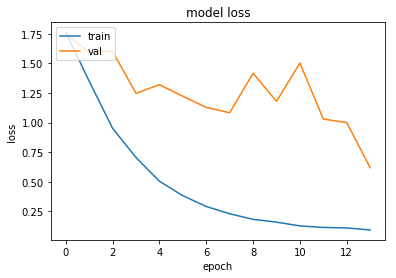

In [22]:
plt.plot(multi_history.history['accuracy'])
plt.plot(multi_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(multi_history.history['loss'])
plt.plot(multi_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [59]:
multi_classifier.save('./model.h5')

Model loss appears broadly stable over 14 epochs; we do not seem to have reached the point of overfitting yet.

In [66]:
# classes are passed through the algorithm in a random order - we want to retrieve the order of the classes
multi_test_names = []
# collect all file names
for i in range(len(multi_test_set.filenames)):
    multi_test_names.append(multi_test_set.filenames[i])
# extract unique names, in order
for i in range(len(multi_test_names)):
    multi_test_names[i] = multi_test_names[i].split("/")[0]
multi_test_name_order = list(OrderedDict.fromkeys(multi_test_names))

In [98]:
from keras.preprocessing import image

names = []
for x in range(len(multi_test_names)):
        if x not in names:
            names.append(multi_test_names[x])
            
        
test_image = image.load_img('./test_multi/George_W_Bush/George_W_Bush_0006.jpg', target_size = (250,250))
test_image =image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis =0)

pred =(multi_classifier.predict(test_image))

i=pred.argmax()

names[i]
pred

array([[3.2422517e-04, 2.1878106e-03, 1.7111565e-01, 5.6896508e-05,
        4.5766882e-03, 8.2173872e-01]], dtype=float32)

In [55]:
multi_predictions_0 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[0] + "/",multi_classifier,binary=False)
multi_predictions_1 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[1] + "/",multi_classifier,binary=False)
multi_predictions_2 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[2] + "/",multi_classifier,binary=False)
multi_predictions_3 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[3] + "/",multi_classifier,binary=False)
multi_predictions_4 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[4] + "/",multi_classifier,binary=False)
multi_predictions_5 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[5] + "/",multi_classifier,binary=False)


NameError: name 'predictions' is not defined

In [56]:
multi_predictions_frame = pd.DataFrame(list(zip(multi_predictions_0 + multi_predictions_1 + multi_predictions_2 + multi_predictions_3 + multi_predictions_4 + multi_predictions_5,
                                                [0] * len(multi_predictions_0) + [1] * len(multi_predictions_1) + [2] * len(multi_predictions_2) + [3] * len(multi_predictions_3) + [4] * len(multi_predictions_4) + [5] * len(multi_predictions_5))),
                                       columns = ['Predictions','Actual'])

NameError: name 'multi_predictions_0' is not defined

In [49]:
multi_accuracy = prec_acc(multi_predictions_frame)
print('Precision:' + str(multi_accuracy[1]))
print('Recall:' + str(multi_accuracy[2]))
print(multi_test_name_order)

NameError: name 'prec_acc' is not defined

These results will be considered in Section 5. Again, we want to drop the used image directories to allow the Kernel to run:

In [ ]:
if "train_multi" in os.listdir("./"):
    shutil.rmtree("./train_multi")
if "val_multi" in os.listdir("./"):
    shutil.rmtree("./val_multi")
if "test_multi" in os.listdir("./"):
    shutil.rmtree("./test_multi")
